In [19]:
%config Completer.use_jedi = False

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv('data/custom_train.csv')

In [3]:
class_label = data['class'].unique()
class_label

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '일반 대화'],
      dtype=object)

In [16]:
#전처리
import re

def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = sentence.replace("\n", "")         # 구분자
    sentence = sentence.replace("\r", "")         # 구분자
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]"," ",sentence)
    sentence = sentence.strip()
    return sentence

In [17]:
data_prepcocessed = data.copy()
data_prepcocessed['conversation'] = data['conversation'].apply(preprocess_sentence)

## EDA

### 워드 클라우드

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [159]:
def generate_wordcloud(df, stopwords=[]):
    all_text = ' '.join(df['conversation'])
#     stopwords = ['내가', '너', '내', '나', '다', '네', '야', '아','SEP','CLS']
    wordcloud = WordCloud(font_path='font/NanumGothic.ttf',stopwords=stopwords).generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

협박 대화 워드클라우드


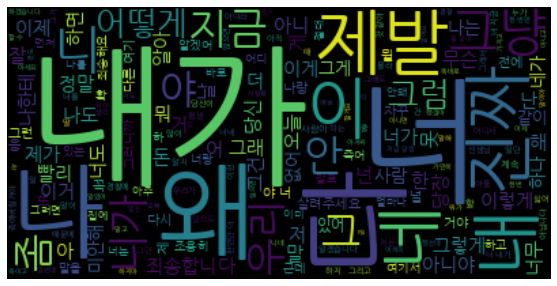

기타 괴롭힘 대화 워드클라우드


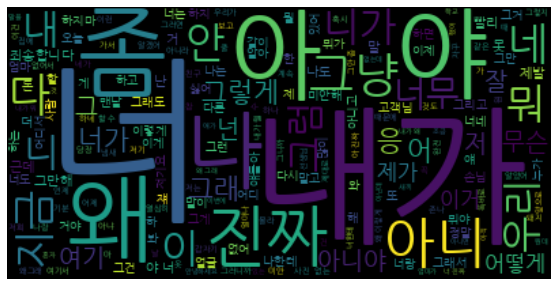

갈취 대화 워드클라우드


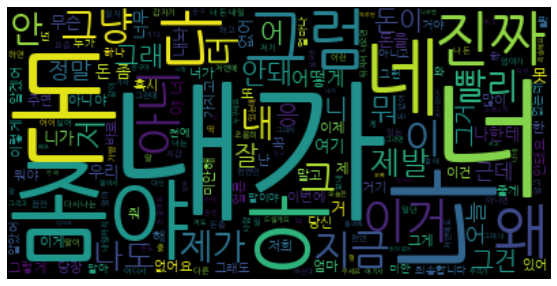

직장 내 괴롭힘 대화 워드클라우드


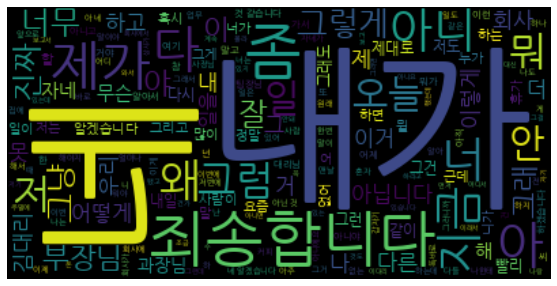

일반 대화 워드클라우드


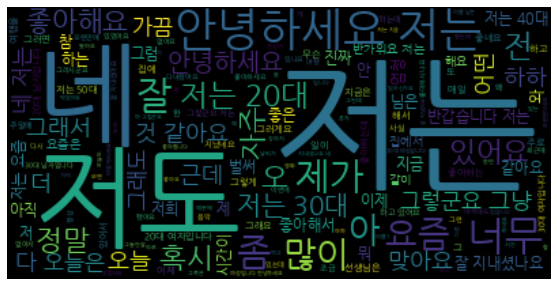

In [92]:
for label in class_label:
    print(f'{label} 워드클라우드')
    generate_wordcloud(data_prepcocessed[data_prepcocessed['class']==label])

### 길이 분포

Text(0, 0.5, '빈도 수')

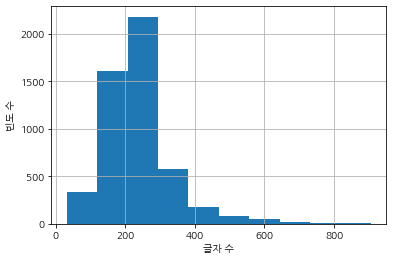

In [24]:
#제목의 글자 수 히스토그램
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] =False

ax = data_prepcocessed['conversation'].str.len().hist()
ax.set_xlabel('글자 수')
ax.set_ylabel('빈도 수')


### 토큰화 이후 분석

In [26]:
X_list = list(np.stack(data_prepcocessed['conversation'].values))


In [25]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [28]:
inputs = tokenizer(X_list)

In [61]:
tokens = inputs.input_ids

In [62]:
series = [pd.Series(row) for row in tokens]

In [81]:
df = pd.DataFrame({'conversation': series})

In [82]:
df['conversation']=df['conversation'].apply(tokenizer.convert_ids_to_tokens)

In [83]:
df['conversation']=df['conversation'].apply(''.join)

In [85]:
df['class']=data['class']

협박 대화 토큰 워드클라우드


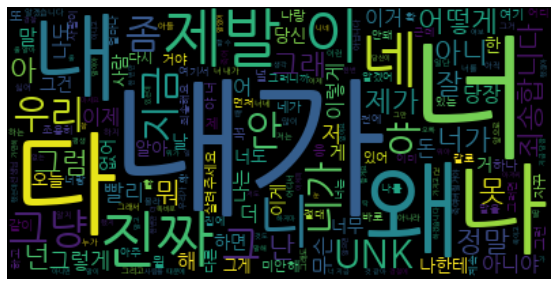

기타 괴롭힘 대화 토큰 워드클라우드


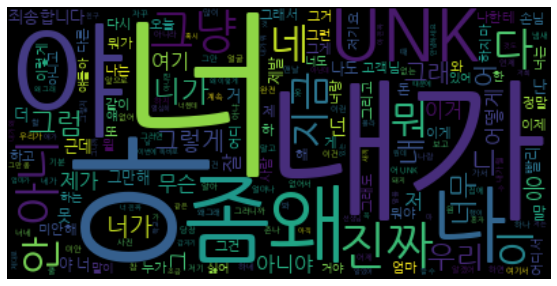

갈취 대화 토큰 워드클라우드


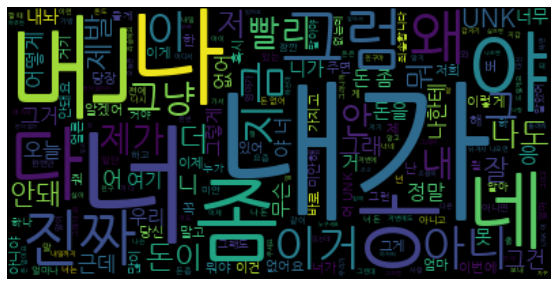

직장 내 괴롭힘 대화 토큰 워드클라우드


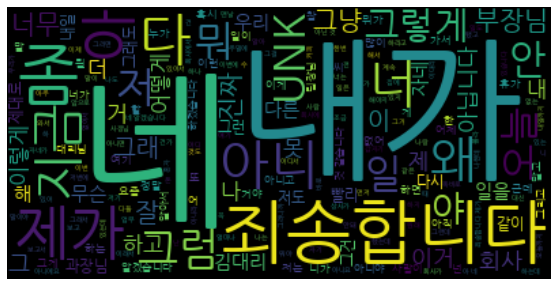

일반 대화 토큰 워드클라우드


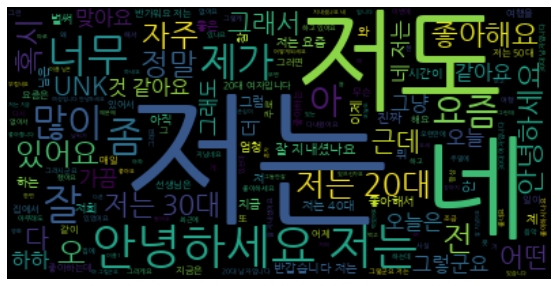

In [91]:
for label in class_label:
    print(f'{label} 토큰 워드클라우드')
    generate_wordcloud(df[df['class']==label], stopwords=['SEP','CLS'])

#### 혼동행렬에서 문제가 있었던 그룹 비교

1. 협박 대화 vs 기타 괴롭힘

In [104]:
label = ['협박 대화', '기타 괴롭힘 대화']
stopwords=['SEP','CLS']

협박 대화 토큰 워드클라우드


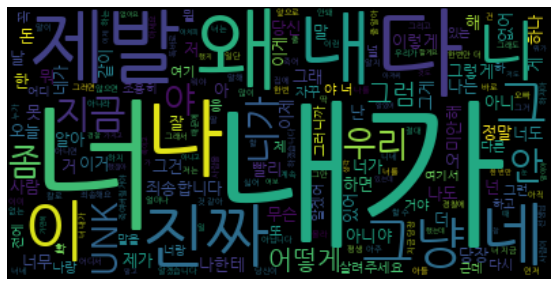

기타 괴롭힘 대화 토큰 워드클라우드


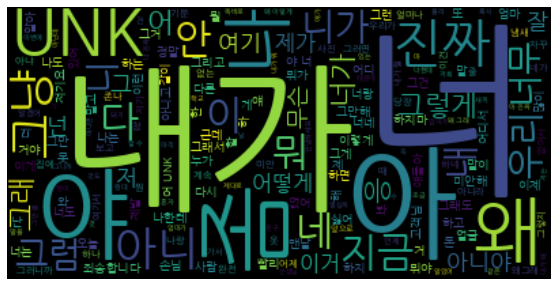

In [103]:
for l in label:
    print(f'{l} 토큰 워드클라우드')
    generate_wordcloud(df[df['class']==l], stopwords=stopwords)

불용어를 제외하고 다시 워드클라우딩하여 차이를 비교  
불용어 사전 출처 : https://www.ranks.nl/stopwords/korean

In [183]:
# 문맥상 진짜 의미가 없는 불용어 제거 
stopwords = ['그렇게','아','어떻게', '이렇게', '그렇군요', '있어요']
# 워드 클라우드에서 보기 편하게 일반어 제거
s = stopwords + ['내가', '다', '니','니가','넌','그냥', '너', '왜', '야','진짜',
                '나','좀', '지금', '내', '아니','우리','네','안','그','이','어',
                '그래', '그럼', '아니야', '응', '너가', '제가', '저', '거','뭐',
                '이거','여기', '저는','저도', '전', '어', '나도', '잘', '너무',
                '정말', '나는', '너도', '네가', '넌', '난', '널']

협박 대화 토큰 워드클라우드


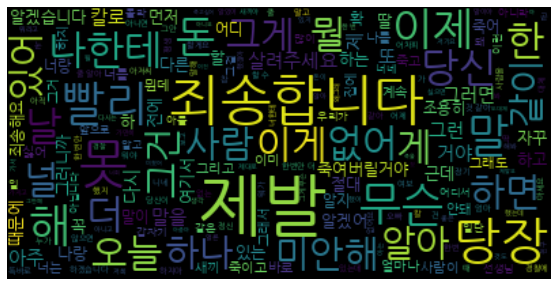

기타 괴롭힘 대화 토큰 워드클라우드


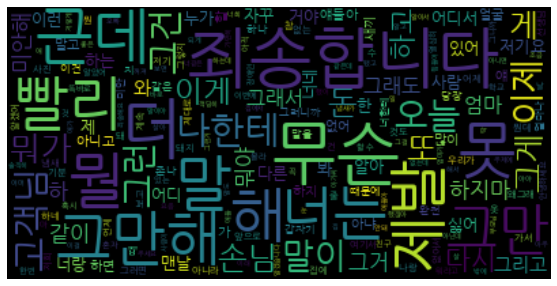

갈취 대화 토큰 워드클라우드


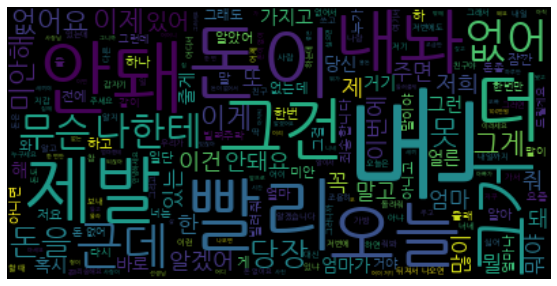

직장 내 괴롭힘 대화 토큰 워드클라우드


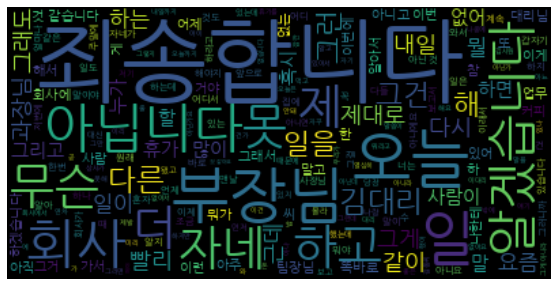

일반 대화 토큰 워드클라우드


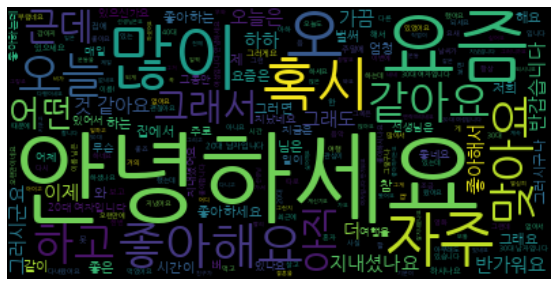

In [184]:
for l in class_label:
    print(f'{l} 토큰 워드클라우드')
    generate_wordcloud(df[df['class']==l], stopwords=['SEP','CLS','UNK']+s)